# ChromVAR Affinity

Run ChromVAR after stratifying by motif affinity, typically on peaks opened newly in high OSK state. See notebook by same name in `20200607_ChromVAR`. Uses BPCell so peak x cell matrix can be recomputed based on custom peak set.

Inputs:
1. BPCell packed fragments.
2. Peaks
3. scATAC Metadata
4. Motif hits in high OSK peaks with affinity scores
5. Fibroblast peaks

In [1]:
library(chromVAR)
library(TFBSTools)
library(BSgenome.Hsapiens.UCSC.hg38)
library(Matrix)
library(SummarizedExperiment)
library(motifmatchr)
library(ggplot2)
library(scales)
library(ggseqlogo)
library(BiocParallel)
library(BPCells)
library(tidyverse)
set.seed(2021)



No methods found in package ‘IRanges’ for request: ‘score’ when loading ‘TFBSTools’

Loading required package: BSgenome

Loading required package: BiocGenerics

Loading required package: parallel


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, Map, mapply, match, mget,
    order, paste, pmax, pmax.int, pmin, pmin.int, Position, rank,
    rbind, Reduce, rownames, sapply, setdiff, sort, table, tapply,
    union, unique, unsplit, which, which.ma

In [2]:
register(MulticoreParam(20, progressbar = TRUE))

## Load Data

In [3]:
# Metadata file from previous run
# should contain, sample_barcode as rowname, sample, umap1, umap2, cluster
metaData = read.table("../../analysis/20200206_pmat_snapATAC/sessions/20210717_n62599/metadata.tsv", header = T)
rownames(metaData) = paste(metaData$sample, metaData$barcode, sep='_')
metaData$cells = rownames(metaData) # for cicero
dim(metaData)
head(metaData, 5)

[1] 62599     6

,barcode,sample,umap1,umap2,cluster,cells
,<fct>,<fct>,<dbl>,<dbl>,<int>,<chr>
D0_AAACACGCTAGTACGG,AAACACGCTAGTACGG,D0,-1.8037916,-9.507773,1,D0_AAACACGCTAGTACGG
D0_AAACACGCTCTTCAAG,AAACACGCTCTTCAAG,D0,0.7074551,-9.406457,1,D0_AAACACGCTCTTCAAG
D0_AAACACGCTGATCCAT,AAACACGCTGATCCAT,D0,-2.9559933,-7.641148,1,D0_AAACACGCTGATCCAT
D0_AAACCCTGACCGCTAG,AAACCCTGACCGCTAG,D0,-3.6119107,-8.443144,1,D0_AAACCCTGACCGCTAG
D0_AAACCCTGATTGCAGT,AAACCCTGATTGCAGT,D0,0.5002119,-8.759449,3,D0_AAACCCTGATTGCAGT


In [4]:
regions = read.table("./tmp/D2_high_OSK/D2_c11.rest.500.bed")
names(regions) = c("chr", "bp1", "bp2")
regions$site_name <- paste(regions$chr, regions$bp1, regions$bp2, sep="_")
row.names(regions) <- regions$site_name
dim(regions)
head(regions)

[1] 534251      4

,chr,bp1,bp2,site_name
,<fct>,<int>,<int>,<chr>
chr17_61927729_61928229,chr17,61927729,61928229,chr17_61927729_61928229
chr17_27753050_27753550,chr17,27753050,27753550,chr17_27753050_27753550
chr17_70552863_70553363,chr17,70552863,70553363,chr17_70552863_70553363
chr17_77374259_77374759,chr17,77374259,77374759,chr17_77374259_77374759
chr17_39139065_39139565,chr17,39139065,39139565,chr17_39139065_39139565
chr17_81023720_81024220,chr17,81023720,81024220,chr17_81023720_81024220


In [5]:
peaks_gr = GRanges(sub("_", "-", sub("_", ":", rownames(regions))))
peaks_gr

GRanges object with 534251 ranges and 0 metadata columns:
           seqnames            ranges strand
              <Rle>         <IRanges>  <Rle>
       [1]    chr17 61927729-61928229      *
       [2]    chr17 27753050-27753550      *
       [3]    chr17 70552863-70553363      *
       [4]    chr17 77374259-77374759      *
       [5]    chr17 39139065-39139565      *
       ...      ...               ...    ...
  [534247]     chrY 17752845-17753345      *
  [534248]     chrY 17807117-17807617      *
  [534249]     chrY   7260941-7261441      *
  [534250]     chrY   7109991-7110491      *
  [534251]     chrY   7936006-7936506      *
  -------
  seqinfo: 24 sequences from an unspecified genome; no seqlengths

In [6]:
length(unique(width(peaks_gr)))

[1] 1

In [7]:
unique(width(peaks_gr))

[1] 501

## Make pmat

In [8]:
pmats = list()
all_bcs = c()

i = 1
for (x in levels(metaData$sample)) {
    packed_fragments <- readRDS(sprintf("/srv/scratch/surag/scATAC-reprog/BPCells/packed/%s.frag.rds", x))
    cells_to_keep = as.character(metaData$barcode)[as.character(metaData$sample)==x]
    pmats[[i]] = packed_fragments %>% select_cells(cells_to_keep) %>% overlapMatrix(peaks_gr)
    pmats[[i]] = as(pmats[[i]], "dgCMatrix")
    
    all_bcs = c(all_bcs, rownames(metaData)[as.character(metaData$sample)==x])
    
    i = i+1
}

In [9]:
pmat = do.call(rbind, pmats)

In [10]:
dim(pmat)

[1]  62599 534251

In [11]:
rm(pmats)
gc()

,used,(Mb),gc trigger,(Mb),max used,(Mb)
Ncells,10141149,541.6,22353170,1193.8,13952005,745.2
Vcells,951724961,7261.1,2696022540,20569.1,2624557655,20023.8


In [12]:
head(all_bcs)

[1] "D0_AAACACGCTAGTACGG" "D0_AAACACGCTCTTCAAG" "D0_AAACACGCTGATCCAT"
[4] "D0_AAACCCTGACCGCTAG" "D0_AAACCCTGATTGCAGT" "D0_AAACCGTACACACCTA"

In [13]:
# make sure cells are in same order as those in metaData
stopifnot(all(all_bcs==rownames(metaData)))

In [14]:
# binarize the matrix (could also do outlier removal)
pmat@x[pmat@x > 0] <- 1

In [15]:
pmatRowSums = Matrix::rowSums(pmat)

In [16]:
pmatColSums = Matrix::colSums(pmat)

In [17]:
min(pmatRowSums)

[1] 490

In [18]:
min(pmatColSums)

[1] 19

Fibroblast peaks

In [19]:
fibr_peaks = read.table("/oak/stanford/groups/akundaje/surag/projects/scATAC-reprog/clusters/20210714_n64913/croo/cluster_idx1/peak/overlap_reproducibility/overlap.optimal_peak.narrowPeak.gz")
fibr_peaks = fibr_peaks[,1:3]
colnames(fibr_peaks) = c("chr", "start", "end")
fibr_peaks = GRanges(fibr_peaks)
fibr_peaks

GRanges object with 283475 ranges and 0 metadata columns:
           seqnames              ranges strand
              <Rle>           <IRanges>  <Rle>
       [1]     chr1 100009510-100009794      *
       [2]     chr1 100036850-100037066      *
       [3]     chr1 100037588-100039175      *
       [4]     chr1 100037588-100039175      *
       [5]     chr1 100037588-100039175      *
       ...      ...                 ...    ...
  [283471]     chrY     7836422-7836664      *
  [283472]     chrY     7873996-7874589      *
  [283473]     chrY     7935906-7936641      *
  [283474]     chrY     7941921-7942148      *
  [283475]     chrY     9141829-9142025      *
  -------
  seqinfo: 24 sequences from an unspecified genome; no seqlengths

In [20]:
# peaks called on D2 cells subsetted to high OSK resolved peaks
d2_high_OSK_peaks = read.table("./tmp/D2_high_OSK/D2_c11.resolved.500.bed")
d2_high_OSK_peaks = d2_high_OSK_peaks[,1:3]
colnames(d2_high_OSK_peaks) = c("chr", "start", "end")
d2_high_OSK_peaks = GRanges(d2_high_OSK_peaks)
d2_high_OSK_peaks

GRanges object with 159472 ranges and 0 metadata columns:
           seqnames            ranges strand
              <Rle>         <IRanges>  <Rle>
       [1]    chr17 61927729-61928229      *
       [2]    chr17 27753050-27753550      *
       [3]    chr17 70552863-70553363      *
       [4]    chr17 77374259-77374759      *
       [5]    chr17 39139065-39139565      *
       ...      ...               ...    ...
  [159468]     chrY 19004557-19005057      *
  [159469]     chrY 56745831-56746331      *
  [159470]     chrY   3038659-3039159      *
  [159471]     chrY 12970823-12971323      *
  [159472]     chrY 12555014-12555514      *
  -------
  seqinfo: 24 sequences from an unspecified genome; no seqlengths

In [21]:
# # # peaks called on D2 cells subsetted to high OSK state
# d2_high_OSK_peaks = read.table("~/oak/projects/scATAC-reprog/clusters/20201020_n62402/croo/cluster_idx4/peak/overlap_reproducibility/overlap.optimal_peak.narrowPeak.gz")
# d2_high_OSK_peaks = d2_high_OSK_peaks[,1:3]
# colnames(d2_high_OSK_peaks) = c("chr", "start", "end")
# d2_high_OSK_peaks = GRanges(d2_high_OSK_peaks)
# d2_high_OSK_peaks

### Make motifs x peak matrix

Take OCTSOX/KLF/other motif hits in peaks in D2 (high OSK) not in fibroblasts. Split into high and low affinity and perform separately.

In [22]:
# motif_hits = read.table("./motif_scans/scans/importance_thresholded/OCTSOX.tsv", header=T)
# motif_hits = GRanges(motif_hits)
# motif_hits

In [23]:
# motif_hits = read.table("../../analysis/20210520_spacing_in_data/scanning/tfmodisco_cluster_idx4_gc_neg_peak_set_8_10_11_13/high_OSK.not.fibr.1000.OCTSOX.top_oneperc_imp.bed")
# colnames(motif_hits) = c("chr", "start", "end", "strand", "score", "seq")
# motif_hits = GRanges(motif_hits)

In [24]:
# motif_hits = read.table("./tmp/OCTSOX.new.scan.agg.imp.thresh.old.highOSK.peaks.bed", header=T)
# colnames(motif_hits) = c("chr", "start", "end", "strand", "score", "seq", "imp")
# # motif_hits$score = motif_hits$new_score
# motif_hits = GRanges(motif_hits)

In [25]:
motif_hits = read.table("./tmp/D2_high_OSK/OCTSOX.imp.threshed.tsv", header=T)
# colnames(motif_hits) = c("chr", "start", "end", "strand", "score", "seq")
# motif_hits$score = motif_hits$new_score
motif_hits = GRanges(motif_hits)

In [26]:
# motif_hits = read.table("./tmp/D2_high_OSK/OCTSOX.raw.bed", header=T)
# colnames(motif_hits) = c("chr", "start", "end", "strand", "score", "seq")
# # motif_hits$score = motif_hits$new_score
# motif_hits = GRanges(motif_hits)

In [27]:
motif_in_fibr_idx = unique(queryHits(findOverlaps(motif_hits, fibr_peaks)))
length(motif_in_fibr_idx) 

{if (length(motif_in_fibr_idx) > 0) {
    motif_non_fibr_hits = motif_hits[-motif_in_fibr_idx]
}
else {
    motif_non_fibr_hits = motif_hits
}
}

[1] 0

In [28]:
motif_in_d2_high_OSK_idx = unique(queryHits(findOverlaps(motif_non_fibr_hits, d2_high_OSK_peaks)))
length(motif_in_d2_high_OSK_idx) 

motif_non_fibr_and_high_OSK_hits = motif_non_fibr_hits[motif_in_d2_high_OSK_idx]

[1] 41133

In [29]:
length(motif_non_fibr_hits)

[1] 41133

In [30]:
length(motif_non_fibr_and_high_OSK_hits)

[1] 41133

In [31]:
quantile(motif_non_fibr_hits$score, c(.25,.5,.95))

25%       50%       95% 
 6.007977  7.373646 10.846472

In [32]:
# motif strengths will be split into these percentile buckets
# SPLITS = c(0,0.2,.4,.6,.8,.9,.95)

SPLITS = c(0,0.4,.9)

In [33]:
motif_x_peak = matrix(0, nrow = length(peaks_gr), ncol=length(SPLITS))

for (i in seq(length(SPLITS))) {
    cur_perc = SPLITS[i]
    cur_hits = motif_non_fibr_and_high_OSK_hits[motif_non_fibr_and_high_OSK_hits$score >= quantile(motif_non_fibr_and_high_OSK_hits$score, cur_perc)]
    motif_x_peak[unique(queryHits(findOverlaps(peaks_gr, cur_hits))), i] = 1
}

In [34]:
colSums(motif_x_peak)

[1] 31624 21108  3996

In [35]:
table(rowSums(motif_x_peak))


     0      1      2      3 
502627  10516  17112   3996 

In [36]:
# assign each peak to strongest
for (i in rev(2:length(SPLITS))) {
    motif_x_peak[motif_x_peak[,i]>0, 1:i-1] = 0
}

In [37]:
colSums(motif_x_peak)

[1] 10516 17112  3996

In [38]:
min(colSums(motif_x_peak))

[1] 3996

In [39]:
table(rowSums(motif_x_peak))


     0      1 
502627  31624 

In [40]:
klf_hits = read.table("./tmp/D2_high_OSK/KLF.imp.threshed.tsv", header=T)
# colnames(klf_hits) = c("chr", "start", "end", "strand", "score", "seq")
# motif_hits$score = motif_hits$new_score
klf_hits = GRanges(klf_hits)

In [41]:
# klf_hits = read.table("./tmp/D2_high_OSK/KLF.raw.bed", header=T)
# colnames(klf_hits) = c("chr", "start", "end", "strand", "score", "seq")
# # motif_hits$score = motif_hits$new_score
# klf_hits = GRanges(klf_hits)

In [42]:
motif_x_peak[unique(queryHits(findOverlaps(peaks_gr, klf_hits))), ] = 0

In [43]:
colSums(motif_x_peak)

[1] 3299 7223 1863

In [91]:
KLF_scores = data.frame(idx=c(), score=c())
for (i in seq(3)) {
    KLF_scores = rbind(KLF_scores,
                       data.frame(idx=i,
                                 score=klf_hits[unique(queryHits(findOverlaps(klf_hits, peaks_gr[motif_x_peak[,i]>0])))]$score))
                                
}


ERROR: Error in data.frame(idx = i, score = klf_hits[unique(queryHits(findOverlaps(klf_hits, : arguments imply differing number of rows: 1, 0


In [130]:
sample(peaks_gr[motif_x_peak[, 1]>0], 10)

GRanges object with 10 ranges and 0 metadata columns:
       seqnames              ranges strand
          <Rle>           <IRanges>  <Rle>
   [1]     chr3   65121917-65122417      *
   [2]     chr7 135948312-135948812      *
   [3]    chr12   95034703-95035203      *
   [4]     chr3   88977649-88978149      *
   [5]     chr4   29362854-29363354      *
   [6]    chr13   73761428-73761928      *
   [7]     chr5 158876560-158877060      *
   [8]    chr13   41741551-41742051      *
   [9]     chr6 108408181-108408681      *
  [10]     chr5 112796019-112796519      *
  -------
  seqinfo: 24 sequences from an unspecified genome; no seqlengths

In [100]:
d2_peaks_only = peaks_gr[unique(queryHits(findOverlaps(peaks_gr, d2_high_OSK_peaks)))]
d2_peaks_only = d2_peaks_only[-unique(queryHits(findOverlaps(d2_peaks_only, fibr_peaks)))]
d2_peaks_only_no_hit = d2_peaks_only[-unique(queryHits(findOverlaps(d2_peaks_only, motif_hits)))]
sample(d2_peaks_only_no_hit, 10)

GRanges object with 10 ranges and 0 metadata columns:
       seqnames              ranges strand
          <Rle>           <IRanges>  <Rle>
   [1]     chr6   48579241-48579741      *
   [2]     chr6 157166126-157166626      *
   [3]    chr16   75445522-75446022      *
   [4]    chr14   92172131-92172631      *
   [5]     chr6   52606365-52606865      *
   [6]    chr12   65373657-65374157      *
   [7]    chr17   51254245-51254745      *
   [8]    chr16   19638485-19638985      *
   [9]    chr14   70618236-70618736      *
  [10]    chr17   51051691-51052191      *
  -------
  seqinfo: 24 sequences from an unspecified genome; no seqlengths

In [105]:
# scores in those high OSK D2 specific peaks without any hit
KLF_scores = rbind(KLF_scores,
                  data.frame(idx=0, 
                            score=klf_hits[unique(queryHits(findOverlaps(klf_hits, d2_peaks_only_no_hit)))]$score))

In [106]:
median(KLF_scores[KLF_scores$idx==1, "score"])
median(KLF_scores[KLF_scores$idx==7, "score"])

[1] 6.646954

[1] NA

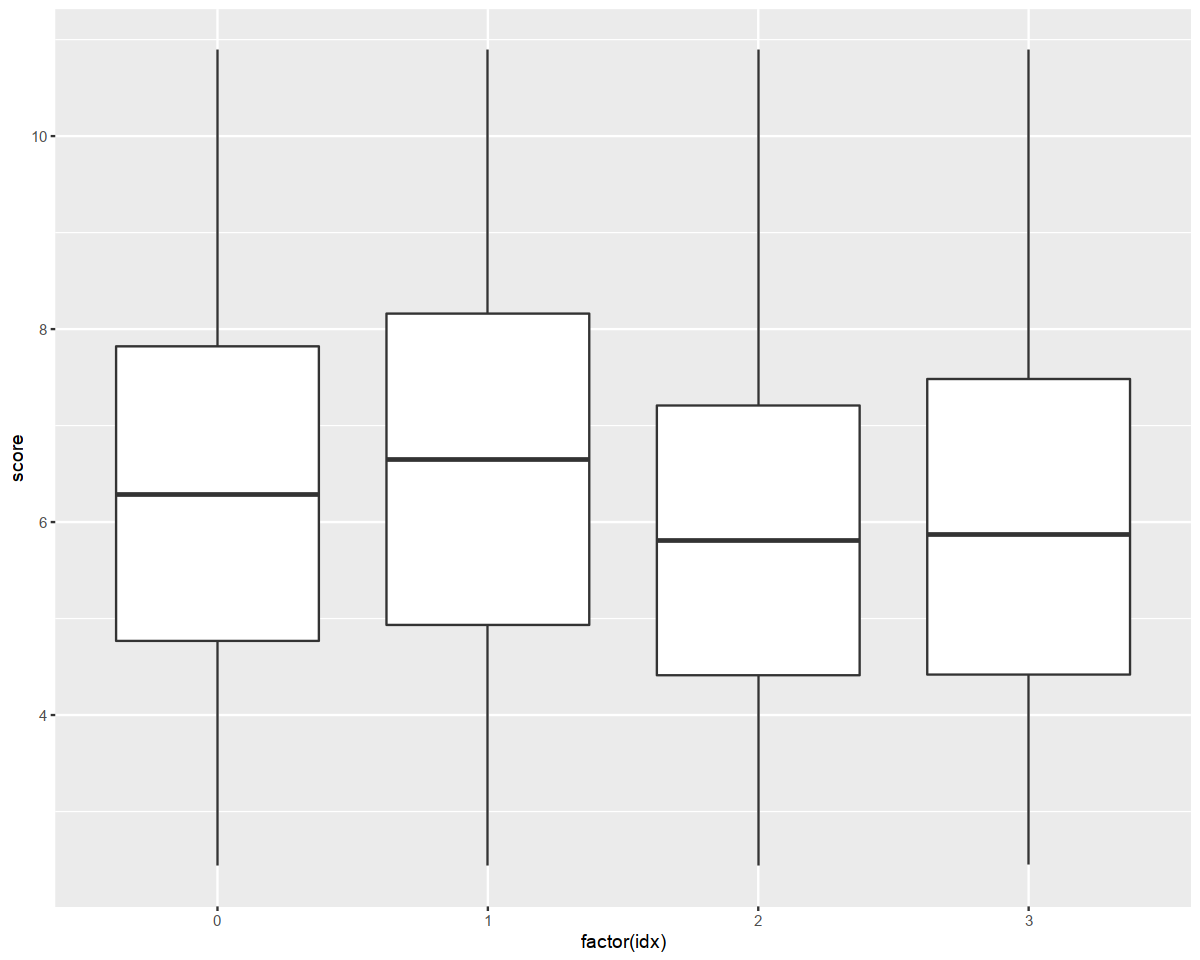

In [107]:
ggplot(KLF_scores) +
geom_boxplot(aes(x=factor(idx),y=score))

In [674]:
# ggplot(KLF_scores %>% group_by(idx) %>% summarise_all(median)) +
# geom_line(aes(x=idx,y=score))

In [44]:
motif_hits_se <- SummarizedExperiment(
                 assays = list(motifMatches = motif_x_peak), 
                 colData = DataFrame(name=SPLITS)
    );

## ChromVAR

In [45]:
GENOME = BSgenome.Hsapiens.UCSC.hg38

In [46]:
rse <- SummarizedExperiment(
                 assays = list(counts = t(pmat)), 
                 rowRanges = peaks_gr, 
                 colData = DataFrame(Cell_Type=1:nrow(pmat), depth=pmatRowSums)
    );

In [47]:
rse <- addGCBias(rse, genome = GENOME);

Use pre-computed matrix, e.g. from hits loaded above

In [48]:
motif_mm <- motif_hits_se

---

In [49]:
motif_mm_mat = assay(motif_mm)
colnames(motif_mm_mat) = motif_mm$name

In [50]:
dev <- computeDeviations(object = rse, annotations = motif_mm)

Warning message in matches_check(annotations):
“Annotation object matches converted to logical”


  |======================================================================| 100%



In [51]:
dev_mat = t(assay(dev))

In [52]:
colnames(dev_mat) = motif_mm$name
rownames(dev_mat) = rownames(metaData)
head(dev_mat)

,0,0.4,0.9
D0_AAACACGCTAGTACGG,-0.6004173,-0.8356066,-1.0165073
D0_AAACACGCTCTTCAAG,-0.7226239,-0.6841676,-0.7965312
D0_AAACACGCTGATCCAT,-0.5824831,-0.8182964,-0.9570523
D0_AAACCCTGACCGCTAG,-0.5314180,-0.6938046,-0.8238033
D0_AAACCCTGATTGCAGT,-0.4594055,-0.4789398,-0.6510463
D0_AAACCGTACACACCTA,-0.6055000,-0.7410395,-0.9271518


In [53]:
# save output
# write.table(dev_mat, file="./out/20201020_n62402/20201119_bpnet.no_iPSC.FDR_0.1_hits.tsv", quote=F, row.names=T, sep='\t')

In [54]:
# variability <- computeVariability(dev)

In [55]:
# head(variability)

In [56]:
# plotVariability(variability, use_plotly = FALSE, n = 20) 

In [57]:
# variability[rev(order(variability$variability)), "name"]

In [164]:
cur_pattern = "0.8"

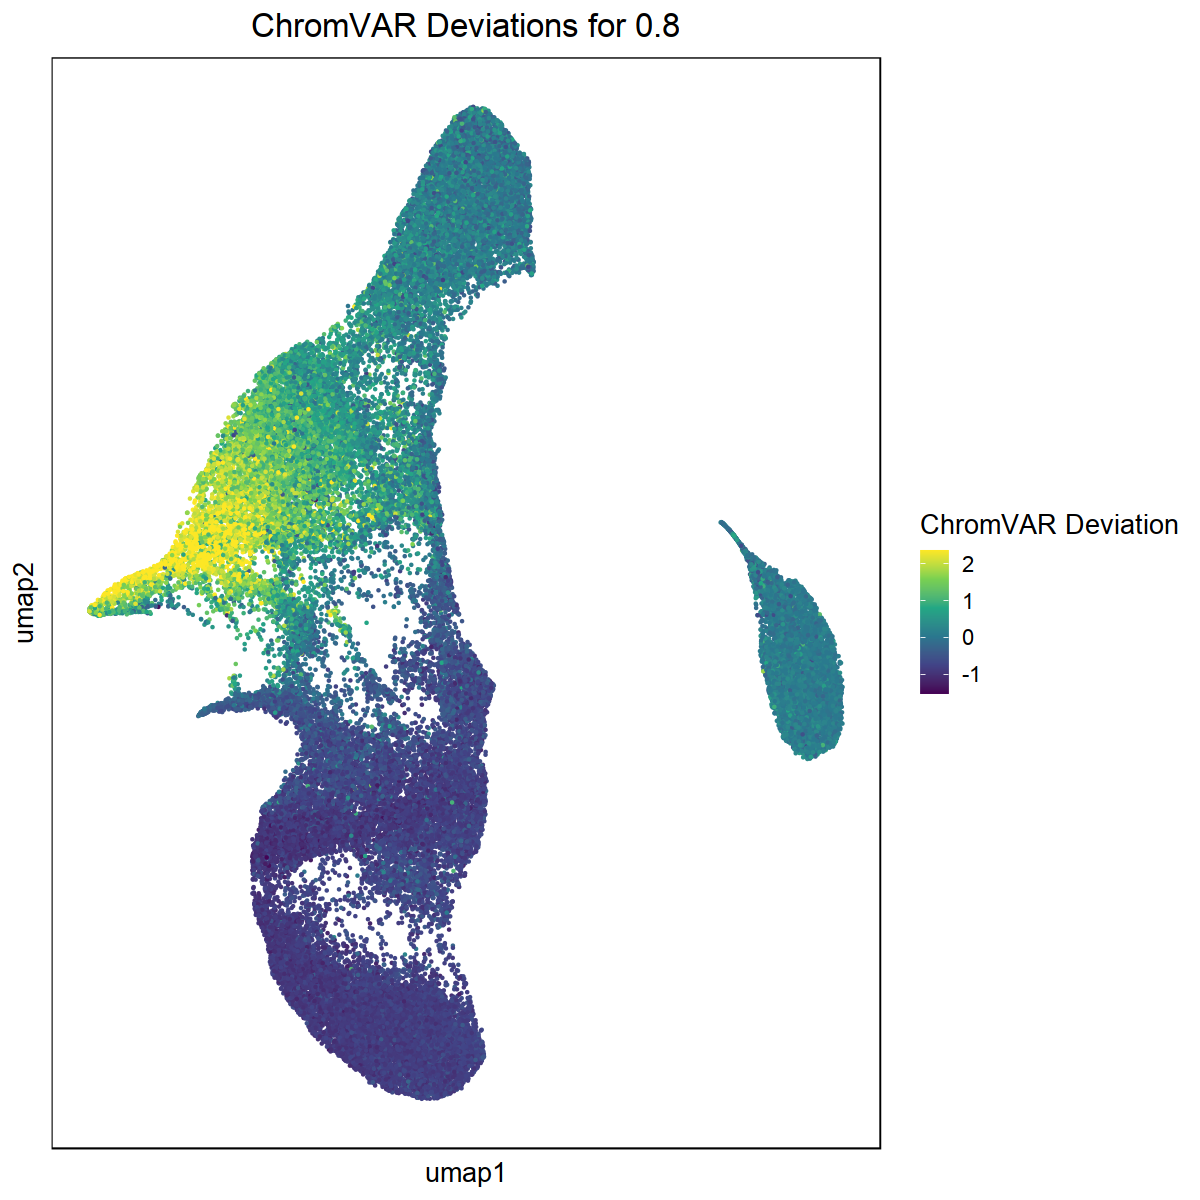

In [165]:
options(repr.plot.width = 10, repr.plot.height = 10)

cur_dev = dev_mat[,cur_pattern]

df = data.frame(metaData, n=cur_dev)
# shuffle so days don't overlap
df = df[sample(dim(df)[1]), ]

ggplot(df) +
geom_point(size=1, stroke=0, alpha=1, aes(x=umap1 , y=umap2, col=n)) +
scale_color_viridis_c(limit=c(quantile(cur_dev, 0.0),
                              quantile(cur_dev, 0.98)), 
                      oob = squish, name='ChromVAR Deviation') +
ggtitle(sprintf("ChromVAR Deviations for %s", cur_pattern)) + 
theme_classic(base_size = 16) +
theme(plot.title = element_text(hjust = 0.5),
     axis.line=element_blank(),
          axis.text.x=element_blank(),
          axis.text.y=element_blank(),
          axis.ticks=element_blank(),
     panel.border = element_rect(colour = "black", fill=NA, size=0.5)) 

# ggsave("tmp.png", height=10, width=10)

In [166]:
sum(motif_mm_mat[, cur_pattern])

[1] 3556

In [167]:
frip = 100*Matrix::rowSums(pmat[, which(motif_mm_mat[, cur_pattern]>0)])/pmatRowSums

In [159]:
cor(frip, dev_mat[,cur_pattern], method='spearman')

[1] 0.7902729

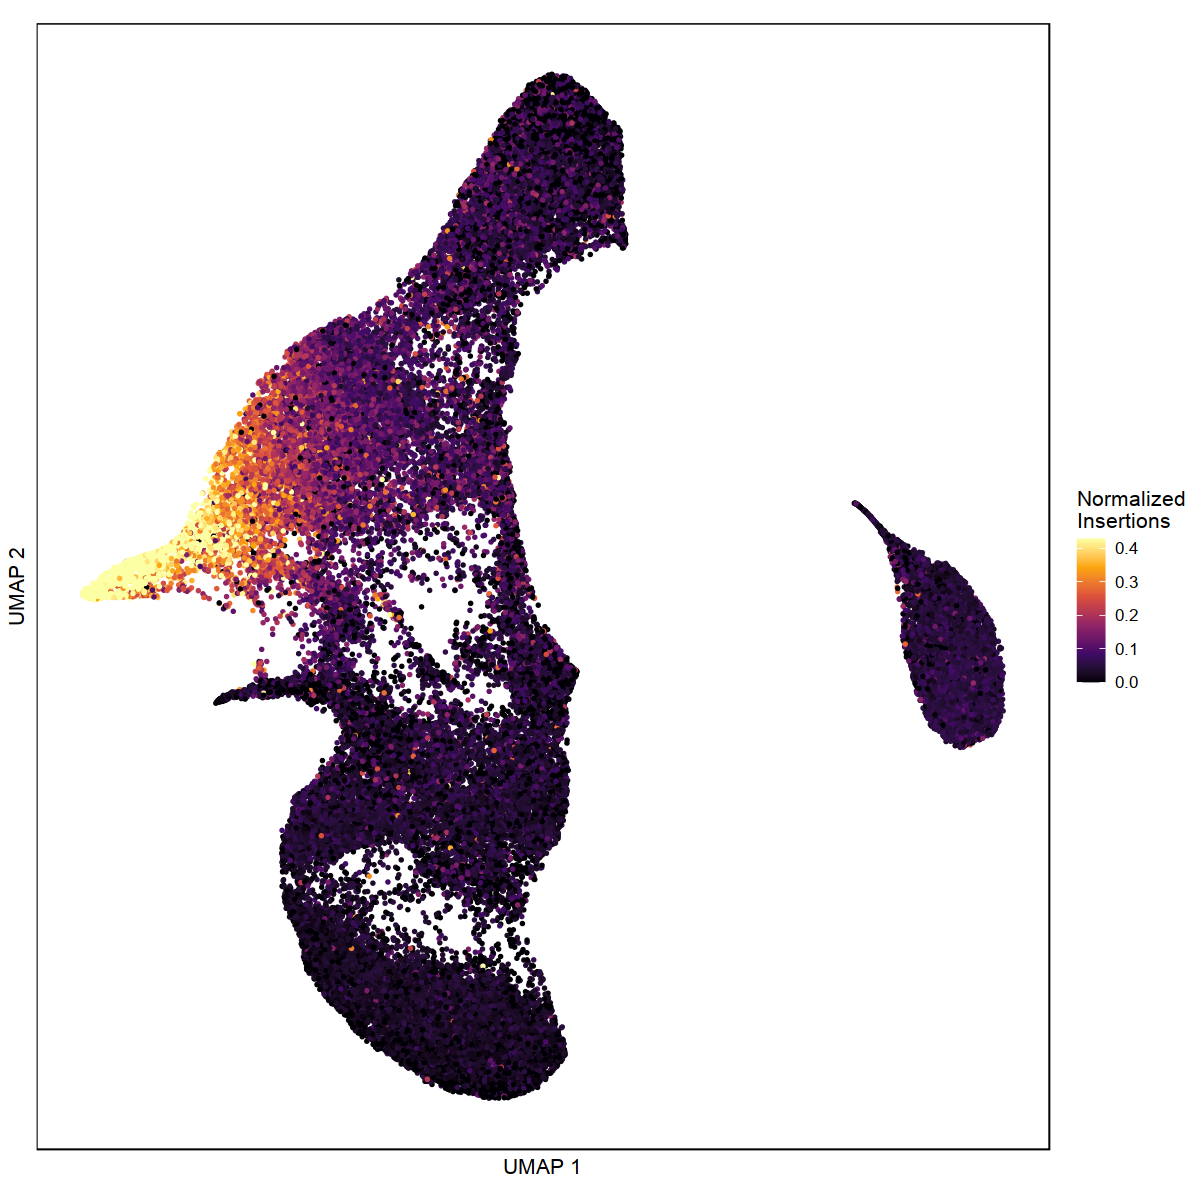

In [160]:
options(repr.plot.width = 10, repr.plot.height = 10)

df = data.frame(metaData, n=frip)
# shuffle so days don't overlap
df = df[sample(dim(df)[1]), ]

frip_plot <- ggplot(df) +
geom_point(size=0.5, alpha=1, aes(x=umap1 , y=umap2, col=n)) +
scale_color_viridis_c(limit=c(quantile(frip, 0.00),
                              quantile(frip, 0.98)), 
                      oob = squish, option="B",
                     name="Normalized\nInsertions") +
theme_classic() +
    xlab("UMAP 1") + ylab("UMAP 2") +
    theme(plot.title = element_text(hjust = 0.5),
          text = element_text(size=12),
          axis.line=element_blank(),
          axis.text.x=element_blank(),
          axis.text.y=element_blank(),
          axis.ticks=element_blank(),
          panel.border = element_rect(colour = "black", fill=NA, size=0.5)) +
# ggtitle(sprintf("FRiP for %s", cur_pattern)) + 
theme(plot.title = element_text(hjust = 0.5)) +
coord_fixed()

frip_plot

In [59]:
library(reshape2)


Attaching package: ‘reshape2’


The following object is masked from ‘package:tidyr’:

    smiths




In [58]:
colSums(is.na(dev_mat))

0 0.4 0.9 
  0   0   0

In [60]:
# if there's an NA
for (x in SPLITS) {
  dev_mat[(is.na(dev_mat[,as.character(x)])), as.character(x)] = mean(dev_mat[,as.character(x)], na.rm=T)  
}
# dev_mat[(is.na(dev_mat[,"0"])), "0.8"] = mean(dev_mat[,"0.8"], na.rm=T)
# dev_mat[(is.na(dev_mat[,"0.8"])), "0.8"] = mean(dev_mat[,"0.8"], na.rm=T)
# dev_mat[(is.na(dev_mat[,"0.8"])), "0.8"] = mean(dev_mat[,"0.8"], na.rm=T)
# dev_mat[(is.na(dev_mat[,"0.9"])), "0.9"] = mean(dev_mat[,"0.9"], na.rm=T)
# dev_mat[(is.na(dev_mat[,"0.95"])), "0.95"] = mean(dev_mat[,"0.95"], na.rm=T)

In [61]:
colSums(is.na(dev_mat))

0 0.4 0.9 
  0   0   0

In [62]:
cluster_mean = aggregate(dev_mat, list(metaData$cluster), mean)
rownames(cluster_mean) = cluster_mean[,"Group.1"]
cluster_mean = cluster_mean[,2:ncol(cluster_mean)]
# cluster_mean[,"Group.1"] = NULL
cluster_mean_norm = t(t(cluster_mean) - colMins(as.matrix(cluster_mean)))
cluster_mean_norm = t(t(cluster_mean_norm)/colMaxs(as.matrix(cluster_mean_norm))) # norm to 0-1

colnames(cluster_mean_norm) = paste(colnames(cluster_mean_norm), c(colnames(cluster_mean_norm)[2:ncol(cluster_mean_norm)],1), sep='-')                              

In [63]:
ORDER = c(11,14,4,5,6,8,1)
ordered_vals = as.data.frame(cluster_mean_norm[ORDER,])

# change rownames to order of samples
rownames(ordered_vals) = rev(seq(nrow(ordered_vals)))

ordered_vals

,0-0.4,0.4-0.9,0.9-1
,<dbl>,<dbl>,<dbl>
7,1.00000000,1.00000000,1.00000000
6,0.48079651,0.68164038,0.94757755
5,0.26140643,0.44518554,0.73560802
4,0.15859531,0.27482881,0.51176009
3,0.13940421,0.22719143,0.41743058
2,0.13125280,0.22173404,0.43704219
1,0.01420213,0.02269351,0.01456412


In [64]:
sum(rowMaxs(as.matrix(ordered_vals))[2:6]-rowMins(as.matrix(ordered_vals))[2:6])

[1] 1.877963

In [65]:
to_plot = melt(as.matrix(ordered_vals))

In [66]:
head(to_plot)

,Var1,Var2,value
,<int>,<fct>,<dbl>
1,7,0-0.4,1.0000000
2,6,0-0.4,0.4807965
3,5,0-0.4,0.2614064
4,4,0-0.4,0.1585953
5,3,0-0.4,0.1394042
6,2,0-0.4,0.1312528


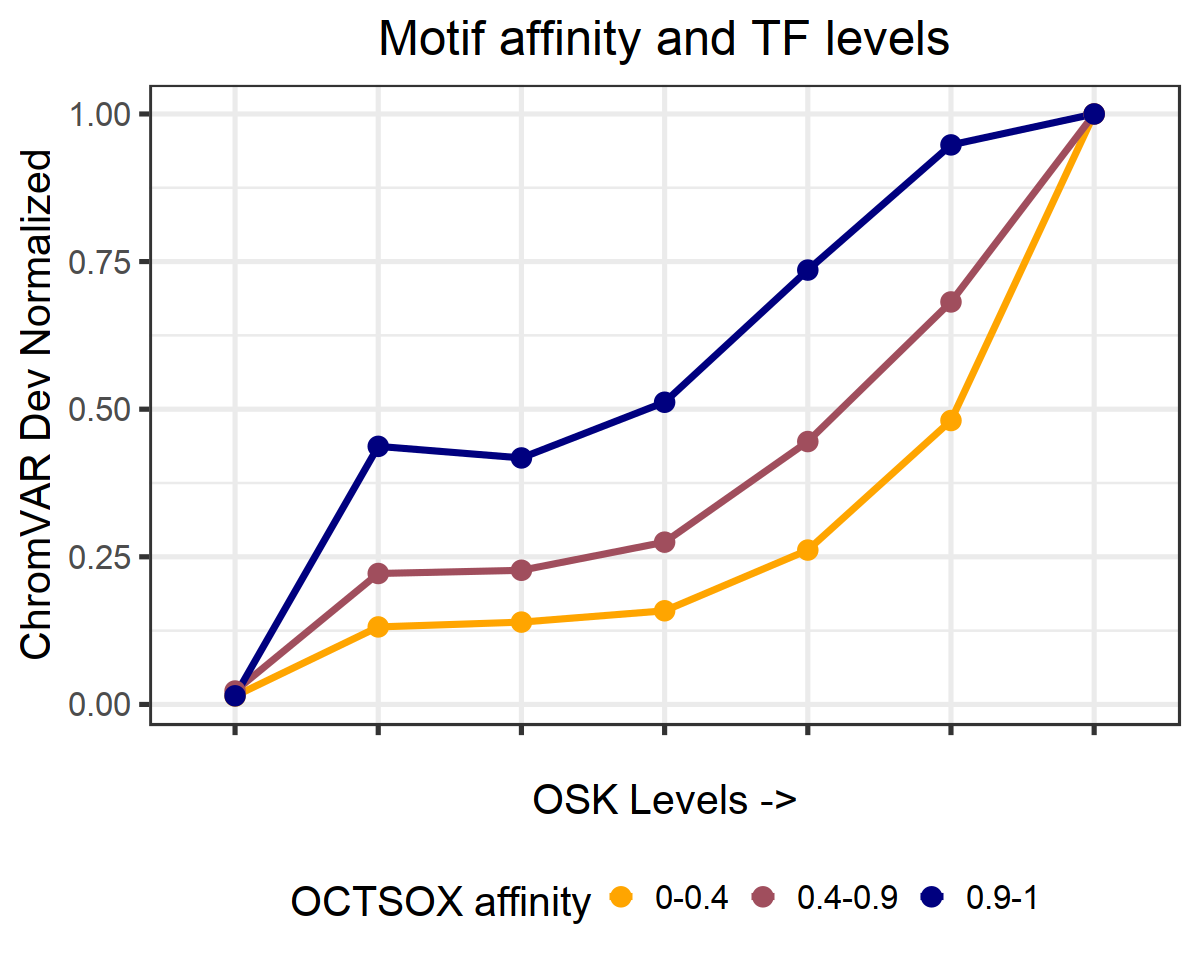

In [67]:
options(repr.plot.width = 10, repr.plot.height = 8)

p <- ggplot(to_plot, aes(x=factor(Var1), y=value, group=Var2, color=factor(Var2, 
                                                           levels=colnames(ordered_vals)))) +
geom_line(size=1.5) + 
geom_point(size=5) +
ylab("ChromVAR Dev Normalized") +
xlab("OSK Levels ->") +
theme_bw(base_size=24) +
ggtitle("Motif affinity and TF levels") +
# scale_color_brewer() +
scale_color_manual(values=colorRampPalette(c("orange","navyblue"), space = "Lab")(length(SPLITS))) +
labs(colour="OCTSOX affinity") +
theme(axis.text.x=element_text(color="white"),
     plot.title = element_text(hjust=0.5),
     legend.position = "bottom")

p

In [108]:
sample(peaks_gr[motif_x_peak[,1] > 0 ], 10)

GRanges object with 10 ranges and 0 metadata columns:
       seqnames              ranges strand
          <Rle>           <IRanges>  <Rle>
   [1]     chr6 113371159-113371659      *
   [2]     chr5 179975676-179976176      *
   [3]    chr16   14850112-14850612      *
   [4]    chr17   72313456-72313956      *
   [5]     chr6   80213213-80213713      *
   [6]     chr5   84425449-84425949      *
   [7]     chr4   70253864-70254364      *
   [8]    chr17   51071690-51072190      *
   [9]    chr12   48647730-48648230      *
  [10]     chr9   20065748-20066248      *
  -------
  seqinfo: 24 sequences from an unspecified genome; no seqlengths

In [787]:
# ggsave("tmp.pdf", p, height=8, width=10)

### Permuted Controls

In [ ]:
# 1 shuffle (for control)
# motif_x_peak[rowSums(motif_x_peak)==1,] = motif_x_peak[(rowSums(motif_x_peak)==1),][sample(sum(rowSums(motif_x_peak)==1)), ]

In [51]:
# multiple permuted controls (have to run in sets of 100)
control_spreads = c()

for (i in range(10)) {
    permuted_controls = list()
    for (i in seq(100)) {
        permuted_controls[[i]] = motif_x_peak
        permuted_controls[[i]][rowSums(motif_x_peak)==1,] = motif_x_peak[(rowSums(motif_x_peak)==1),][sample(sum(rowSums(motif_x_peak)==1)), ]
        colnames(permuted_controls[[i]]) = paste(i, SPLITS, sep='_')
     }

    permuted_controls = do.call(cbind, permuted_controls)
    
    motif_hits_se <- SummarizedExperiment(
                 assays = list(motifMatches = permuted_controls), 
                 colData = DataFrame(name=colnames(permuted_controls))
    );
    
    motif_mm <- motif_hits_se
    motif_mm_mat = assay(motif_mm)
    colnames(motif_mm_mat) = motif_mm$name
        
    dev <- computeDeviations(object = rse, annotations = motif_mm)
    dev_mat = t(assay(dev))
    
    colnames(dev_mat) = motif_mm$name
    rownames(dev_mat) = rownames(metaData)
    
    # aggregate over clusters
    cluster_mean = aggregate(dev_mat, list(metaData$cluster), mean)
    rownames(cluster_mean) = cluster_mean[,"Group.1"]
    cluster_mean = cluster_mean[,2:ncol(cluster_mean)]
    # cluster_mean[,"Group.1"] = NULL
    cluster_mean_norm = t(t(cluster_mean) - colMins(as.matrix(cluster_mean)))
    cluster_mean_norm = t(t(cluster_mean_norm)/colMaxs(as.matrix(cluster_mean_norm))) # norm to 0-1

    colnames(cluster_mean_norm) = paste(colnames(cluster_mean_norm), c(colnames(cluster_mean_norm)[2:ncol(cluster_mean_norm)],1), sep='-')
    
    ORDER = c(4,8,2,7,1,5)
    ordered_vals = as.data.frame(cluster_mean_norm[ORDER,])

    # change rownames to order of samples
    rownames(ordered_vals) = rev(seq(nrow(ordered_vals)))

    # compute spreads
    for (i in seq(100)) {
        cur = as.matrix(ordered_vals[,((i-1)*length(SPLITS)+1):(i*length(SPLITS))])
        control_spreads = c(control_spreads, sum(rowMaxs(cur)-rowMins(cur)))
    }
}

Warning message in matches_check(annotations):
“Annotation object matches converted to logical”


  |======================================================================| 100%



Warning message in matches_check(annotations):
“Annotation object matches converted to logical”


  |======================================================================| 100%



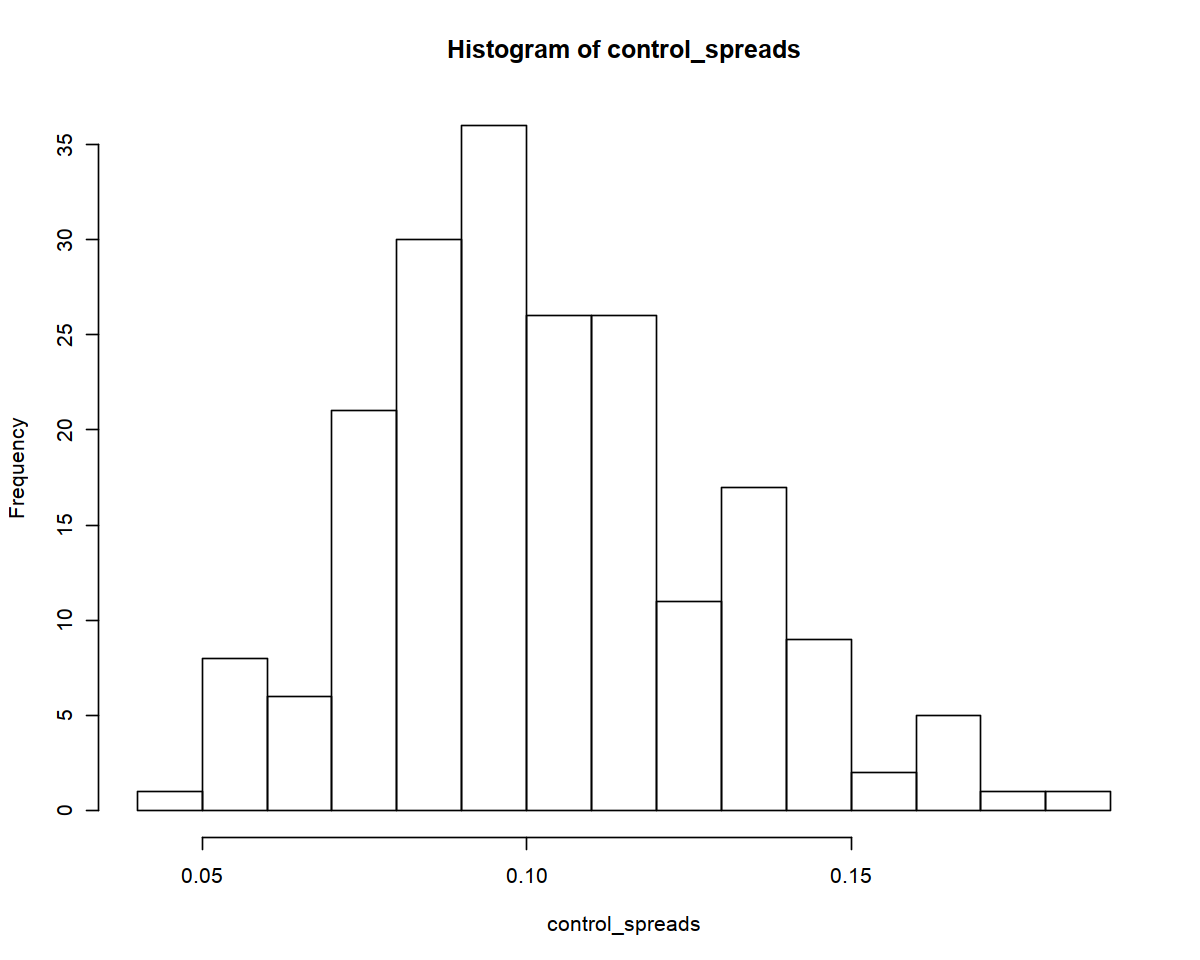

In [55]:
hist(control_spreads, breaks=13)

In [57]:
to_plot = melt(as.matrix(ordered_vals))

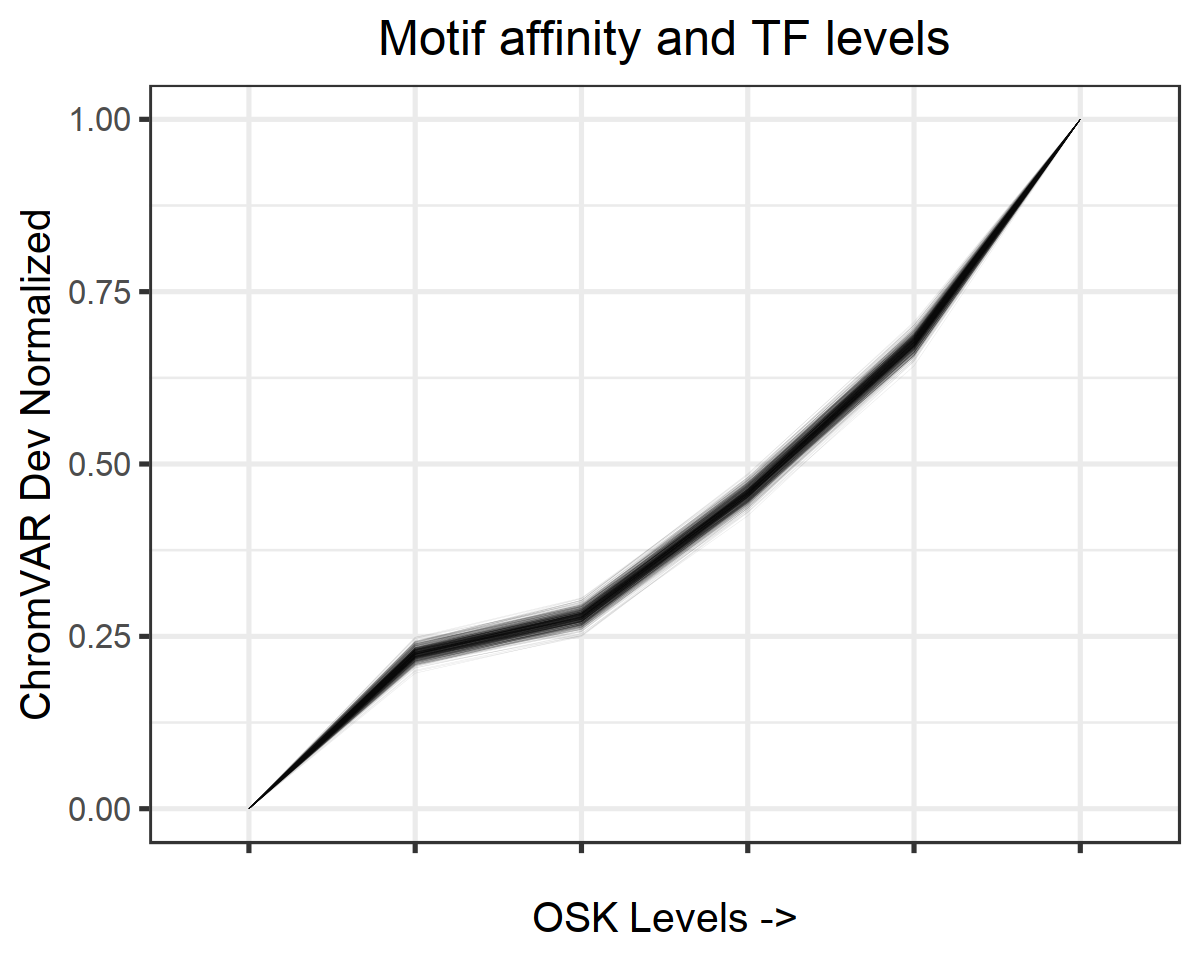

In [82]:
options(repr.plot.width = 10, repr.plot.height = 8)

p <- ggplot(to_plot, aes(x=factor(Var1), y=value, group=Var2)) +
geom_line(size=.1, color='black', alpha=.1) + 
# geom_point(size=5) +
ylab("ChromVAR Dev Normalized") +
xlab("OSK Levels ->") +
theme_bw(base_size=24) +
ggtitle("Motif affinity and TF levels") +
# scale_color_brewer() +
# scale_color_manual(values=colorRampPalette(c("orange","navyblue"), space = "Lab")(length(SPLITS)*100)) +
labs(colour="OCTSOX affinity") +
theme(axis.text.x=element_text(color="white"),
     plot.title = element_text(hjust=0.5),
     legend.position = "bottom")

p

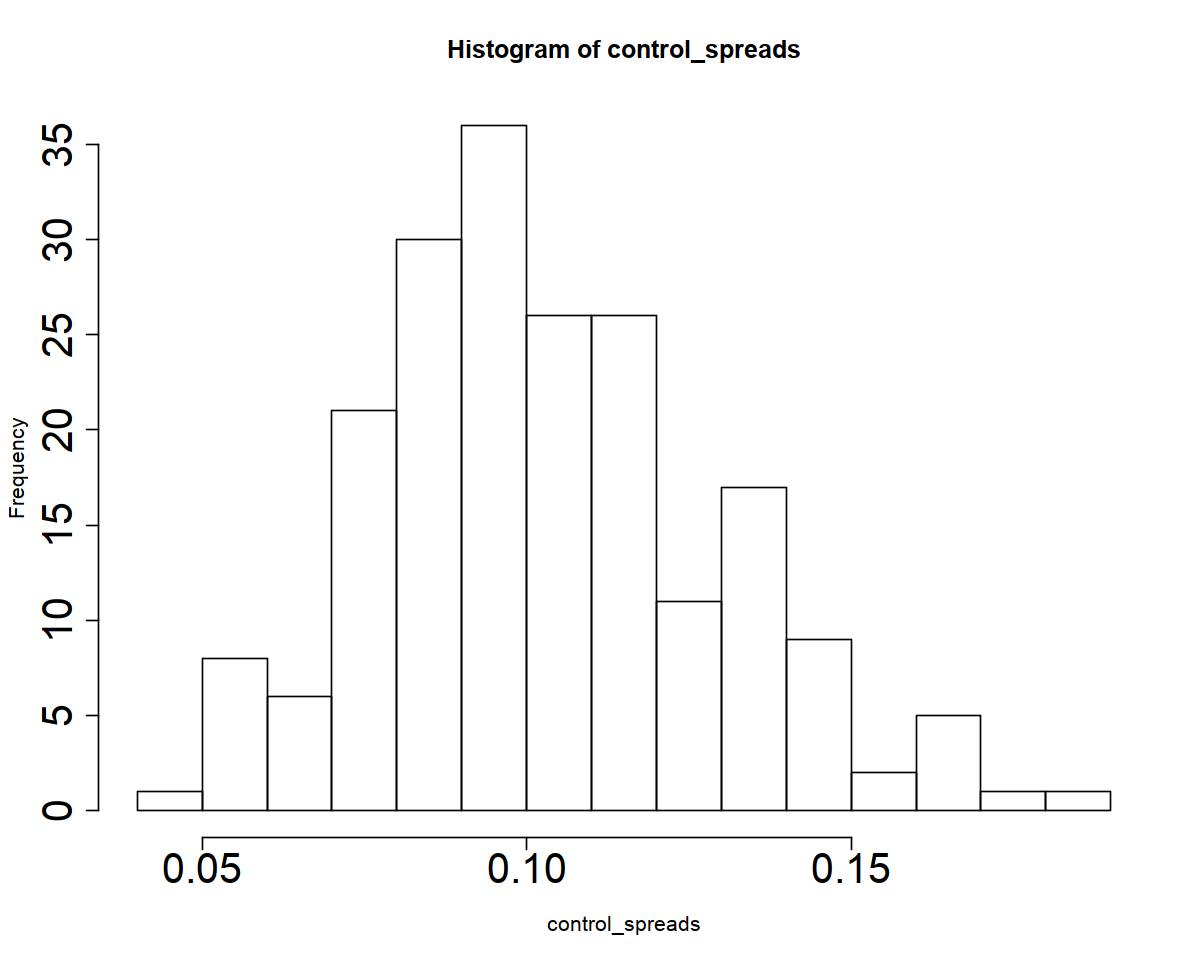

In [78]:
hist(control_spreads, breaks=10, cex.axis=2)

### SessionInfo

In [519]:
sessionInfo()

R version 3.6.3 (2020-02-29)
Platform: x86_64-conda_cos6-linux-gnu (64-bit)
Running under: Ubuntu 18.04.5 LTS

Matrix products: default
BLAS/LAPACK: /users/surag/anaconda3/envs/r36_cran/lib/libopenblasp-r0.3.9.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] stats4    parallel  stats     graphics  grDevices utils     datasets 
[8] methods   base     

other attached packages:
 [1] reshape2_1.4.4                    ggseqlogo_0.1                    
 [3] scales_1.1.0                      ggplot2_3.3.3                    
 [5] motifmatchr_1.8.0                 SummarizedExperiment_1.16.1      
 [7] DelayedArray_0.12.3               BiocParallel_1.20